In [4]:
import pandas as pd
from datetime import datetime
from datetime import date
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import unicodedata
import math
from itertools import cycle
import xlsxwriter
import pyodbc

import random
from IPython.display import display, HTML

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [5]:
def calcula_dv(rut_base):
    # Convertir el RUT base a una cadena y revertirla
    reversed_digits = list(map(int, str(rut_base)[::-1]))
    # Definir los factores (2..7) que se repiten en ciclo
    factors = list(range(2, 8))
    # Calcular la suma de los productos
    suma = sum(d * f for d, f in zip(reversed_digits, factors * (len(reversed_digits) // len(factors) + 1)))
    # Calcular el dígito verificador
    dv = (-suma) % 11
    return 'K' if dv == 10 else str(dv)

def remove_leading_zeros(rut):
    rut_part, dv = rut.split('-')
    rut_part = rut_part.lstrip('0')
    if not rut_part:
        rut_part = '0'
    return f"{rut_part}-{dv}"

def reemplazar_k(identificador):
    return identificador[:-1:] + identificador[-1].upper()

def separar_rut(numero):
    numero_str = str(numero)
    # Tomar los últimos 1 dígito y el resto
    parte_numerica = numero_str[:-1]
    digito_verificador = numero_str[-1]
    # Formatear el RUT con el guion
    rut_formateado = f"{parte_numerica}-{digito_verificador}"
    return rut_formateado

In [6]:
identificador = '8950806-1'

In [11]:

query_universal = {
    'query_CustodiaClientes': f"""
        SELECT
            C.fecha_cierre,
            C.PRECIO_TASA_MERCADO,
            C.PRECIO_TASA_COMPRA,
            V.NUM_CUENTA,
            V.DSC_CUENTA AS NOMBRE_CLI,
            C.CANTIDAD AS LIBRE,
            C.GARANTIA,
            C.COMPRAS_PLAZO,
            C.VENTAS_PLAZO,
            CASE 
                WHEN PRESTAMOS IS NULL THEN 0 
                ELSE PRESTAMOS 
            END AS PRESTAMOS_ACC,
            V.IDENTIFICADOR,
            I.NEMOTECNICO,
            V.NOMBRE_ASESOR,
            CASE 
                WHEN COD_SUB_CLASE_INSTRUMENTO IN ('CFI', 'ACC') AND I.COD_MONEDA = 'CLP' THEN CANTIDAD * PRECIO_TASA_MERCADO 
                WHEN COD_SUB_CLASE_INSTRUMENTO IN ('CFI', 'ACC') AND I.COD_MONEDA <> 'CLP' THEN (VALOR_MERCADO_CLP / (CANTIDAD + GARANTIA) * CANTIDAD)
                ELSE (VALOR_MERCADO_CLP / (CANTIDAD + GARANTIA) * CANTIDAD) 
            END AS LIBRE_CLP,
            CASE 
                WHEN COD_SUB_CLASE_INSTRUMENTO IN ('CFI', 'ACC') AND I.COD_MONEDA = 'CLP' THEN GARANTIA * PRECIO_TASA_MERCADO 
                WHEN COD_SUB_CLASE_INSTRUMENTO IN ('CFI', 'ACC') AND I.COD_MONEDA <> 'CLP' THEN (VALOR_MERCADO_CLP / (CANTIDAD + GARANTIA) * GARANTIA)
                ELSE (VALOR_MERCADO_CLP / (CANTIDAD + GARANTIA) * GARANTIA) 
            END AS GARANTIA_CLP,
            C.COMPRAS_PLAZO * C.PRECIO_TASA_MERCADO AS SIM_COMPRA_CLP,
            C.VENTAS_PLAZO * C.PRECIO_TASA_MERCADO AS SIM_VENTA_CLP,
            C.VALOR_MERCADO_CLP,
            I.COD_SUB_CLASE_INSTRUMENTO
        FROM
            dbo.cierre_cartera_resumida AS C WITH (NOLOCK)
            INNER JOIN dbo.VIEW_CUENTAS AS V WITH (NOLOCK) ON C.ID_CUENTA = V.ID_CUENTA
            INNER JOIN dbo.INSTRUMENTO AS I WITH (NOLOCK) ON C.ID_INSTRUMENTO = I.ID_INSTRUMENTO
        WHERE
            C.fecha_cierre BETWEEN CONVERT(datetime, '2023-07-19', 120) AND CONVERT(datetime, '2024-09-11', 120)
            AND DATEPART(weekday, C.fecha_cierre) = 6 -- Si los viernes son el día 6 en tu configuración regional
            AND V.IDENTIFICADOR = '8950806-1';
    """
}

# CONN TO DB
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=tcp:mi-sql-prd-002.5bf1e89c8cf2.database.windows.net;DATABASE=capitaria;UID=pablobustamante;PWD=S3cur3!PassPB5sta#2024')
# EXECUTE
df_cartera_detalle = pd.read_sql(query_universal['query_CustodiaClientes'], conn)
# CLOSE
conn.close()



C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_25976\3099708471.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cartera_detalle = pd.read_sql(query_universal['query_CustodiaClientes'], conn)


In [42]:
df_cartera_detalle = df_cartera_detalle.groupby(['IDENTIFICADOR','fecha_cierre']).sum('VALOR_MERCADO_CLP').reset_index()
df_cartera_detalle

,IDENTIFICADOR,fecha_cierre,ID_ASESOR,PRECIO_TASA_MERCADO,PRECIO_TASA_COMPRA,ID_CUENTA,LIBRE,GARANTIA,COMPRAS_PLAZO,VENTAS_PLAZO,PRESTAMOS_ACC,LIBRE_CLP,GARANTIA_CLP,SIM_COMPRA_CLP,SIM_VENTA_CLP,VALOR_MERCADO_CLP
0,8950806-1,2023-07-29,130.0,42360.8400,41860.9296,905740.0,53728.0,0.0,0.0,0.0,0.0,6.964479e+07,0.0,0.0,0.0,69644790.0
1,8950806-1,2023-08-05,130.0,42370.0400,41860.9296,905740.0,53728.0,0.0,0.0,0.0,0.0,6.987989e+07,0.0,0.0,0.0,69879890.0
2,8950806-1,2023-08-12,130.0,42378.3400,41860.9296,905740.0,53728.0,0.0,0.0,0.0,0.0,6.998000e+07,0.0,0.0,0.0,69979998.0
3,8950806-1,2023-08-19,130.0,42352.0400,41860.9296,905740.0,53728.0,0.0,0.0,0.0,0.0,6.990577e+07,0.0,0.0,0.0,69905769.0
4,8950806-1,2023-08-26,130.0,42324.0400,41860.9296,905740.0,53728.0,0.0,0.0,0.0,0.0,6.990309e+07,0.0,0.0,0.0,69903092.0
5,8950806-1,2023-09-02,130.0,42389.0400,41860.9296,905740.0,53728.0,0.0,0.0,0.0,0.0,7.030546e+07,0.0,0.0,0.0,70305461.0
6,8950806-1,2023-09-09,130.0,42466.1400,41866.9489,905740.0,61879.0,0.0,0.0,0.0,0.0,8.111353e+07,0.0,0.0,0.0,81113529.0
7,8950806-1,2023-09-16,130.0,42457.7400,41866.9489,905740.0,61879.0,0.0,0.0,0.0,0.0,8.100913e+07,0.0,0.0,0.0,81009128.0
8,8950806-1,2023-09-23,130.0,42422.2400,41866.9489,905740.0,61879.0,0.0,0.0,0.0,0.0,8.088373e+07,0.0,0.0,0.0,80883729.0
9,8950806-1,2023-09-30,130.0,42389.0400,41866.9489,905740.0,61879.0,0.0,0.0,0.0,0.0,8.066413e+07,0.0,0.0,0.0,80664128.0


C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_25976\1317962443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cartera_detalle_2['fecha_cierre'] = pd.to_datetime(df_cartera_detalle_2['fecha_cierre'])


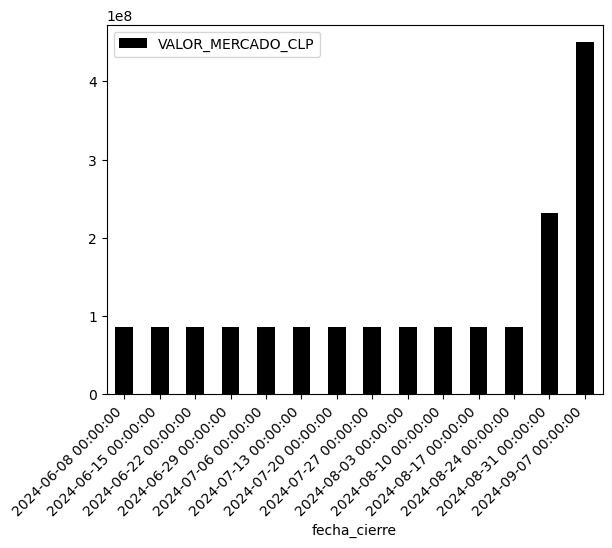

In [41]:
df_cartera_detalle_2['fecha_cierre'] = pd.to_datetime(df_cartera_detalle_2['fecha_cierre'])


df_cartera_detalle_2.plot(kind='bar', 
                          x='fecha_cierre', 
                          y='VALOR_MERCADO_CLP', 
                          color='black')


plt.xticks(rotation=45, ha='right')
plt.show()

## it changes the date to 1970 and it is not like tgat